## Продвинутые архитектуры свёрточных нейросетей

Обучить СНС с помощью Transfer Learning на датасете [Food-101](https://www.tensorflow.org/datasets/catalog/food101?hl=uk)
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]


In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета Food-101

In [92]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
                        'food101', 
                        # shuffle_files= True,
                        as_supervised=True,
                        with_info=True,
                        split=['validation[:90%]', 'validation[90%:]'],
)

In [93]:
ds_info.description

"This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels."

In [94]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [95]:
num_classes = len(class_names)
num_classes

101

## Визуализация датасета Food-101

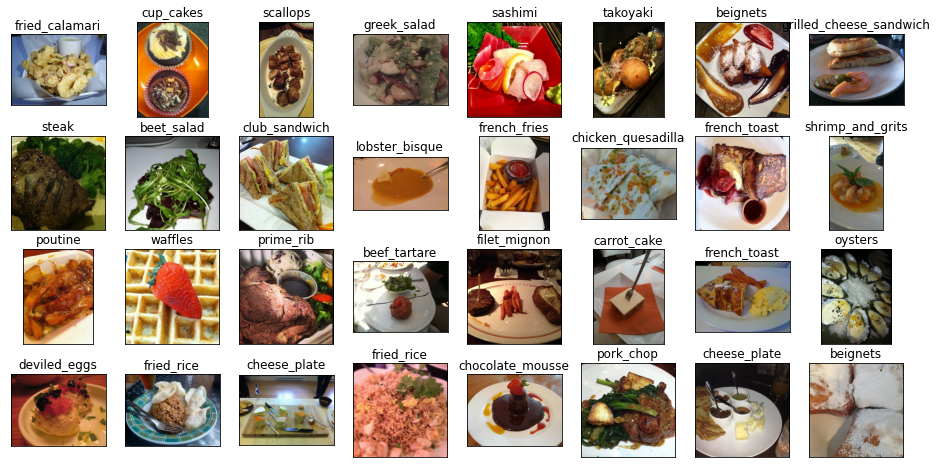

In [96]:
some_samples = []
some_labels =[] 

for x in iter(test_ds.take(32)):
    some_samples.append(x[0])
    some_labels.append(x[1]) 

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    ax.title.set_text(class_names[some_labels[j]])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [97]:
INP_SIZE = 224
NUM_EPOCHS = 1
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/255.0
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [98]:
train_ds, test_ds

(<BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.int64)>)

# Подготовка модели CNN

In [99]:
WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

# CBR(32, (3,3), padding='same', kernel_regularizer=wd),

In [100]:
EXP_NAME = 'transfer'
base_model = tf.keras.applications.MobileNetV2(
                      input_shape=(INP_SIZE, INP_SIZE, 3),
                      include_top=False,
                      weights='imagenet',
                      )

for layer in base_model.layers[:-10]:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.kernel_regularizer=wd

base_out = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(base_out)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=wd)(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

## Model Summary

In [101]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

## Подготовка к обучению

In [102]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
                               log_dir='logs/'+EXP_NAME, 
                                write_graph=False, update_freq=100, 
                                profile_batch=0)

# Directory where the checkpoints will be saved
checkpoint_dir = './checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

## Обучение модели

In [103]:
NUM_EPOCHS = 20

In [104]:
# checkpoint_dir = './checkpoints'
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [106]:
# %%time
history = model.fit(
                    train_ds,
                    epochs=NUM_EPOCHS,
                    validation_data=test_ds,
                    # steps_per_epoch=len(train_ds),
                    # validation_steps=int(0.15 * len(test_ds)),
                    callbacks=[tensorboard_callback, checkpoint_callback]
                   )

Epoch 1/20
710/710 [==============================] - 972s 1s/step - loss: 3.3057 - accuracy: 0.3290 - val_loss: 2.8190 - val_accuracy: 0.4002
Epoch 2/20
710/710 [==============================] - 948s 1s/step - loss: 2.4016 - accuracy: 0.4990 - val_loss: 2.2849 - val_accuracy: 0.5052
Epoch 3/20
710/710 [==============================] - 931s 1s/step - loss: 2.0439 - accuracy: 0.5745 - val_loss: 2.0915 - val_accuracy: 0.5505
Epoch 4/20
710/710 [==============================] - 895s 1s/step - loss: 1.8241 - accuracy: 0.6239 - val_loss: 1.9931 - val_accuracy: 0.5793
Epoch 5/20
710/710 [==============================] - 898s 1s/step - loss: 1.6601 - accuracy: 0.6617 - val_loss: 1.9832 - val_accuracy: 0.5765
Epoch 6/20
710/710 [==============================] - 926s 1s/step - loss: 1.5104 - accuracy: 0.6970 - val_loss: 1.9153 - val_accuracy: 0.5905
Epoch 7/20
710/710 [==============================] - 952s 1s/step - loss: 1.3943 - accuracy: 0.7229 - val_loss: 1.9247 - val_accuracy: 0.5929

## Оценка качества модели

In [107]:
%%time
results = model.evaluate(test_ds)
results # pred.shape()

78/78 [==============================] - 8s 92ms/step - loss: 1.8886 - accuracy: 0.5990
CPU times: user 29.7 s, sys: 283 ms, total: 30 s
Wall time: 8.61 s


[1.8885619640350342, 0.5989583134651184]

## TensorBoard

In [108]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22551), started 10:46:50 ago. (Use '!kill 22551' to kill it.)

## Запуск предсказания на нашем изображении

In [109]:
# results = model.evaluate(test_ds)
# results

In [110]:
some_samples = []
some_labels =[] 
for x in iter(test_ds.take(32)):
    some_samples.append(x[0])
    some_labels.append(x[1]) 
# some_labels = [x[1] for x in iter(test_ds.take(32))]

In [111]:
# some_labels = [x[1] for x in iter(test_ds.take(32))]

In [112]:
# some_labels

In [113]:
pred = model.predict(some_samples[0])

In [114]:
pred_y = tf.argmax(pred, axis=1, output_type=tf.int32)

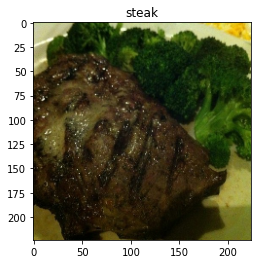

In [115]:
plt.imshow(some_samples[0][5])
plt.title(class_names[some_labels[0][5]])
plt.show()

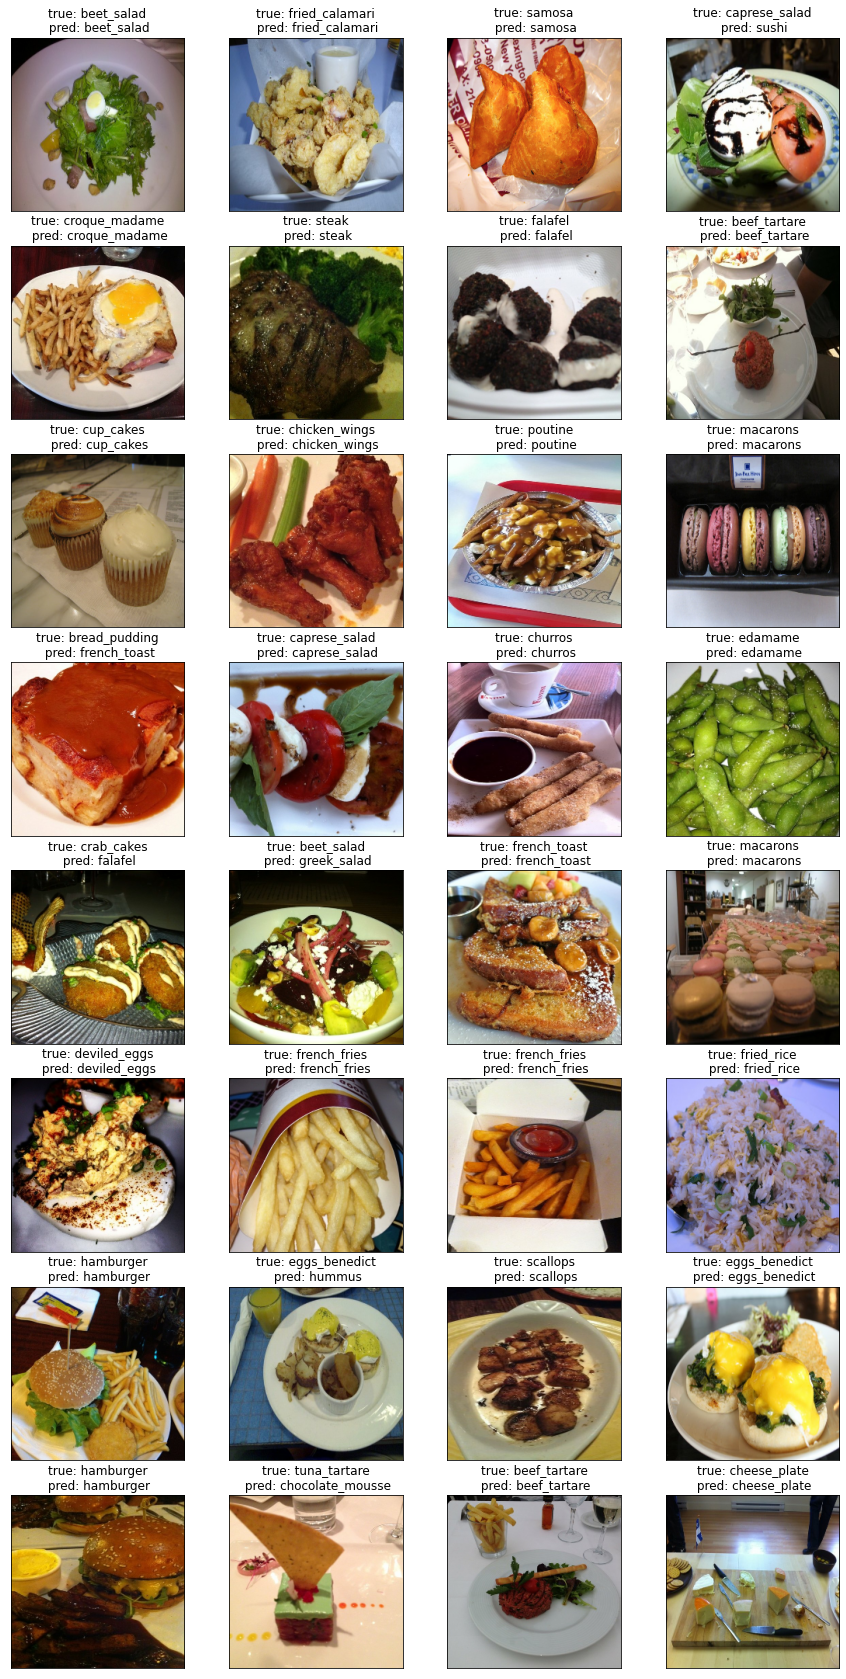

In [116]:
fig = plt.figure(figsize=(15, 30))
for j in range(len(some_samples[0])):
    ax = fig.add_subplot(8, 4, j+1)
    ax.imshow(some_samples[0][j])
    ax.title.set_text(f'true: {class_names[some_labels[0][j]]}\n pred: {class_names[pred_y[j]]}')
    plt.xticks([]), plt.yticks([])
plt.show()